In [ ]:
# Setting up the PySpark environment

# Install java 8
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Apache Spark binary: This link can change based on the version. Update this link with the latest version before using
!wget -q https://downloads.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz

# Unzip file
!tar -xf spark-3.3.0-bin-hadoop2.tgz

# Install findspark: Adds Pyspark to sys.path at runtime
#!pip install -q findspark

# Install pyspark and SparkNLP
!pip install -q pyspark==3.3.0 spark-nlp==4.0.1

# Install pytrends- Google Trends API
!pip install pytrends
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends

# Add environmental variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop2"

# findspark will locate spark in the system
#import findspark
#findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.com/ubuntu bionic-upda

In [ ]:
# Initialize a SparkSession to use a sparkContext
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("The Trends of Youtube Capstone Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
# Show the sparkContext we will use
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=The Trends of Youtube Capstone Project>

In [ ]:
# Load in the data sets into a spark Dataframe
#ca_df = spark.read.csv("Youtube Data/CAvideos.csv", inferSchema = True, header = True)
#de_df = spark.read.csv("Youtube Data/DEvideos.csv", inferSchema = True, header = True)
#fr_df = spark.read.csv("Youtube Data/FRvideos.csv", inferSchema = True, header = True)
#gb_df = spark.read.csv("Youtube Data/GBvideos.csv", inferSchema = True, header = True)
#jp_df = spark.read.csv("Youtube Data/JPvideos.csv", inferSchema = True, header = True)
#kr_df = spark.read.csv("Youtube Data/KRvideos.csv", inferSchema = True, header = True)
#mx_df = spark.read.csv("Youtube Data/MXvideos.csv", inferSchema = True, header = True)
us_df = spark.read.csv("USvideos.csv", inferSchema = False, header = True)

#ca_id = spark.read.json("Youtube Data/CA_category_id.json")
#de_id = spark.read.csv("Youtube Data/DE_category_id.json")
#fr_id = spark.read.csv("Youtube Data/FR_category_id.json")
#gb_id = spark.read.csv("Youtube Data/GB_category_id.json")
#jp_id = spark.read.csv("Youtube Data/JP_category_id.json")
#kr_id = spark.read.csv("Youtube Data/KR_category_id.json")
#mx_id = spark.read.csv("Youtube Data/MX_category_id.json")
us_id = spark.read.csv("US_category_id.json")
us_df.cache() # Cache the dataframes to speed up later computations

DataFrame[video_id: string, trending_date: string, title: string, channel_title: string, category_id: string, publish_time: string, tags: string, views: string, likes: string, dislikes: string, comment_count: string, thumbnail_link: string, comments_disabled: string, ratings_disabled: string, video_error_or_removed: string, description: string]

In [ ]:
# Delete thumbnail_link, comments_disabled, ratings_disabled, video_error_or_removed columns if necessary (there are multiple entries of the same video_id if the video is put on the trending page more than once)

def initial_clean(df):
  df = df.drop('thumbnail_link') # Drop the thumbnail column
  df = df.drop('description') # Drop the description column

  df = df.filter(us_df.video_error_or_removed == False) # Delete rows that had a video error or were removed
  df = df.drop('video_error_or_removed') # Don't need the video error or removed column anymore --> not needed for the analysis

  return df

us_df = initial_clean(us_df)

In [ ]:
# Change the default schema of the US data frame as a general function
from pyspark.sql import functions as F # allows you to use DataFrame, math, collection, datetime, aggregate, sort, etc. functions
from pyspark.sql import types as T # allows you to use different data type transformations in DataFrames

from pyspark.sql.functions import regexp_replace
#sqlContext = SQLContext(sc) # Create a sql context from the spark context
#us_df = sqlcontext.inferSchema(us_df.rdd) # Infer the schema of underlying RDD- did not work

def changeYoutubeDataTypes(df):
  df = df.withColumn("category_id", F.col("category_id").cast("int")) # Change the type of the category_id column into an int from string
  df = df.withColumn("publish_time", F.col("publish_time").cast("timestamp")) # Change the type of the publish_time column into a timestamp from string
  df = df.withColumn("publish_date", F.to_date(F.col("publish_time"))) # Extract the date from the timestamp to measure difference in days between trending date and publish date
  df = df.drop("publish_time")
  df = df.withColumn("views", F.col("views").cast("int")) # Change the type of the views column into an int from string
  df = df.withColumn("likes", F.col("likes").cast("int")) # Change the type of the likes column into an int from string
  df = df.withColumn("dislikes", F.col("dislikes").cast("int")) # Change the type of the dislikes column into an int from string
  df = df.withColumn("comment_count", F.col("comment_count").cast("int")) # Change the type of the comment_count column into an int from string
  
  return df


us_df = changeYoutubeDataTypes(us_df) # Use the function on all data frames
us_df.printSchema() # Print the new schema of the data frame

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- publish_date: date (nullable = true)



In [ ]:
# Add a time_diff column to measure the difference in time between trending and posting
import pandas as pd

def create_days_trending(df): # To create our response variable, days_to_trending
  pd_df = df.toPandas()
  pd_df["trending_date"] = "20" + pd_df["trending_date"]
  pd_df["trending_date_new"] = pd.to_datetime(pd_df["trending_date"], format = "%Y.%d.%m").dt.strftime("%Y-%m-%d") # Change the trending_date col of string type to datetime in pandas and change the format to date in spark
  df = spark.createDataFrame(pd_df)
  df = df.withColumn("trending_date_new", F.col("trending_date_new").cast("date")) # Change the data type of the trending_date column from string
  df = df.withColumn("days_to_trending", F.datediff(F.col("trending_date_new"),F.col("publish_date"))) # Create a new column that finds the difference between publish and trending date, our response var
  df = df.drop("trending_date")

  df = df.withColumn("views_growth", F.col("views") / F.col("days_to_trending")) # Create a column to represent average view growth rate for the trending videos as a predictor using new days_to_trending col
  return df

us_df = create_days_trending(us_df)


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler # StringIndexer creates dummy vars out of categorical columns, VectorAssembler combines multiple columns into a single column

comments_indexer = StringIndexer(inputCol = "comments_disabled", outputCol = "comments_disabled_ind")
ratings_indexer = StringIndexer(inputCol = "ratings_disabled", outputCol = "ratings_disabled_ind")



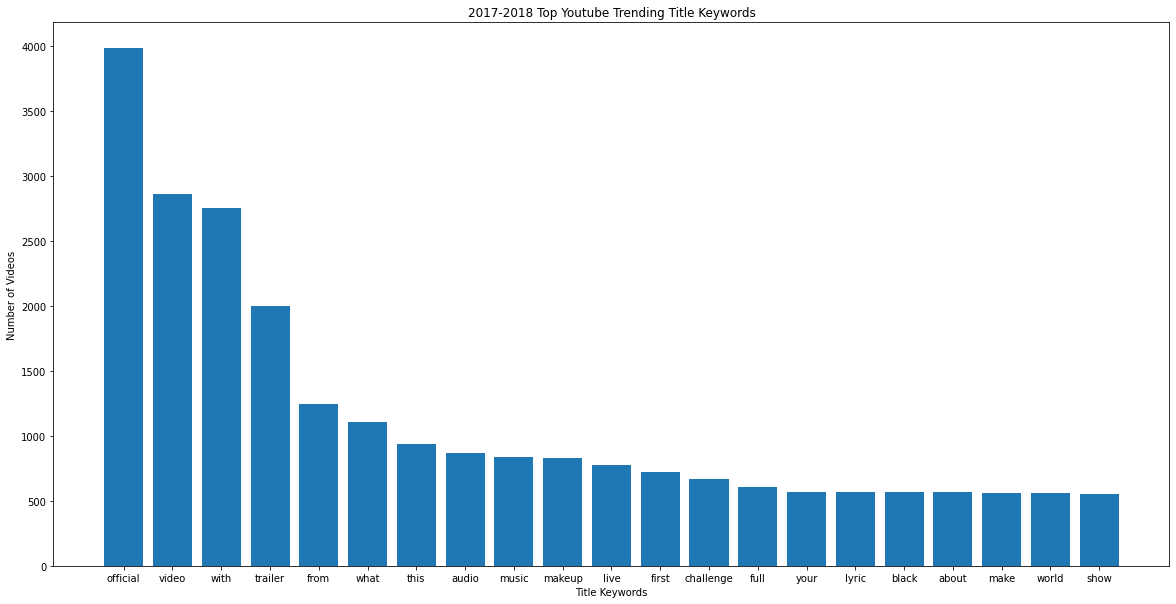

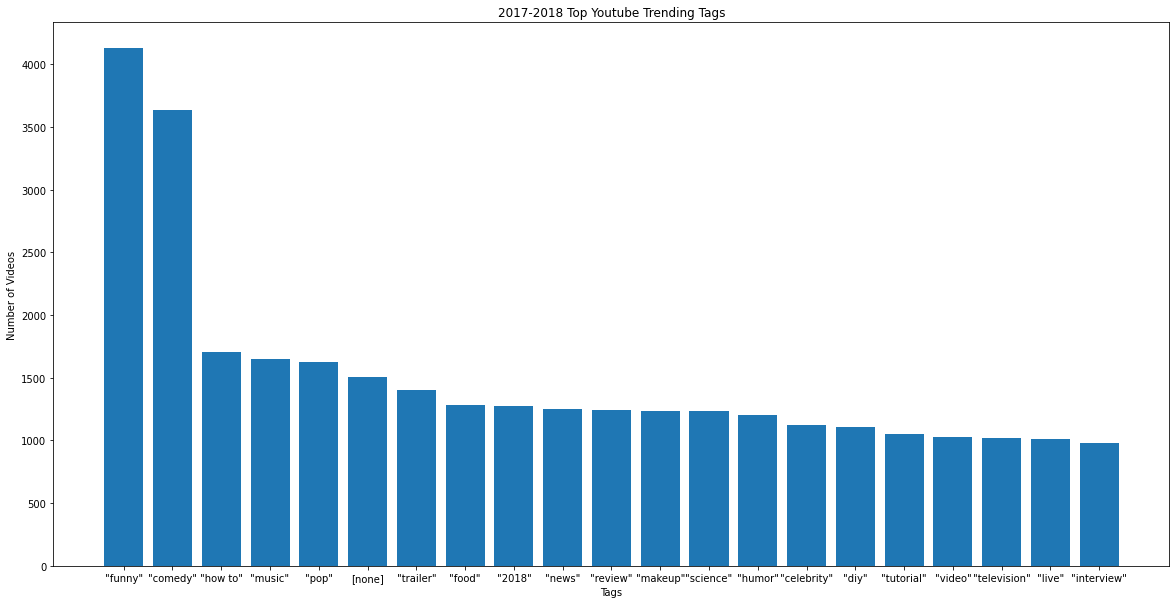

In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

# Compare with google trends data to convert the word/phrase into a google trend score and that score predicts the trending date (create two columns, 
# one to measure commonality of words/phrases in youtube trending and the other to measure google trending)
# import the TrendReq method from the pytrends request module

from pytrends.request import TrendReq
from pylab import *
from pytrends.exceptions import ResponseError
import random

pytrends = TrendReq()

def tokenize_cols(df):
  #import sparknlp
  #from sparknlp.pretrained import PretrainedPipeline

  #nlp = sparknlp.start()
  from pyspark.ml.feature import Tokenizer, RegexTokenizer

  tokenizer_title = RegexTokenizer(inputCol = "title", outputCol = "title_keywords", pattern = "[\\W | 0-9]") # Separate the words of the title and save the words in an array
  df = tokenizer_title.transform(df)

  tokenizer_tags = RegexTokenizer(inputCol = "tags", outputCol = "tag_keywords", pattern = "\|") # Separates the tags of the videos and saves them into an array
  df = tokenizer_tags.transform(df)

  df = df.drop("title", "tags", "description") # Drops the string columns from the df
  df = df.withColumn("time_frame_to_trend", F.concat(F.col("publish_date"), F.lit(" "), F.col("trending_date_new")))
  
  return df

def getKeyWords(word_arry): # return only words 4 letters long or above
  # execute the TrendReq method by passing the host language (hl) and timezone (tz) parameters

  word_arry = [x for x in word_arry if len(x) >= 4] # Only keeps words at least 4 characters long
  
  return word_arry

#us_df = tokenize_cols(us_df)

yt_trend_udf = F.udf(lambda x: getKeyWords(x), T.ArrayType(T.StringType()))
us_df = us_df.withColumn("title_keywords", F.array_distinct(F.col("title_keywords")))
us_df = us_df.withColumn("title_keywords", yt_trend_udf("title_keywords"))
us_df = us_df.withColumn("tag_keywords", yt_trend_udf("tag_keywords"))

trends_df = us_df.select(us_df.video_id, F.explode(us_df.title_keywords)).groupBy("col").count().sort("count", ascending = False).toPandas()
tag_trends_df = us_df.select(us_df.video_id, F.explode(us_df.tag_keywords)).groupBy("col").count().sort("count", ascending = False).toPandas()

trends_top20 = trends_df.iloc[:21]
tag_trends_top20 = tag_trends_df.iloc[:21]

plt.subplots(figsize = (20,10))
plt.bar(trends_top20["col"], trends_top20["count"])
plt.title("2017-2018 Top Youtube Trending Title Keywords")
plt.ylabel("Number of Videos")
plt.xlabel("Title Keywords")
plt.show()

plt.subplots(figsize = (20,10))
plt.bar(tag_trends_top20["col"], tag_trends_top20["count"])
plt.title("2017-2018 Top Youtube Trending Tags")
plt.ylabel("Number of Videos")
plt.xlabel("Tags")
plt.show()





In [ ]:
"""import pandas as pd     
import numpy as np                   
from pytrends.request import TrendReq
pytrend = TrendReq()

#provide your search terms
kw_list=['Facebook', 'Apple', 'Amazon', 'Netflix', 'Google']

#search interest per region
#run model for keywords (can also be competitors)
beg = '2022-05-20'
end = '2022-05-21'
tme = beg + " " + end

pytrend.build_payload(kw_list, timeframe = tme)

scores_df = pytrend.interest_over_time() # create a dataframe out of the trending scores
score_array = [] # Create an empty array to hold the average Google Trending Score
score_array = scores_df.mean()"""
  


'import pandas as pd     \nimport numpy as np                   \nfrom pytrends.request import TrendReq\npytrend = TrendReq()\n\n#provide your search terms\nkw_list=[\'Facebook\', \'Apple\', \'Amazon\', \'Netflix\', \'Google\']\n\n#search interest per region\n#run model for keywords (can also be competitors)\nbeg = \'2022-05-20\'\nend = \'2022-05-21\'\ntme = beg + " " + end\n\npytrend.build_payload(kw_list, timeframe = tme)\n\nscores_df = pytrend.interest_over_time() # create a dataframe out of the trending scores\nscore_array = [] # Create an empty array to hold the average Google Trending Score\nscore_array = scores_df.mean()'

In [ ]:
# Build data model to predict trending date with at least title, tags, description(?), views growth rate, total views, likes, dislikes, comment_count, category using 2017-2018 data
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor # Use the flexible ML method RF to predict days_to_trending
from pyspark.ml.evaluation import RegressionEvaluator # To evaluate our RF model

us_df = us_df.na.drop()

(train_df, test_df) = us_df.randomSplit([0.7, 0.3], 8)
# Convert features into vector (Change this to fit youtube trending data)
inputCols = ["category_id", "views", "likes", "dislikes", "comment_count", "views_growth", "comments_disabled_ind", "ratings_disabled_ind"]
outputCol = "trending_features"
vector_assembler = VectorAssembler(inputCols = inputCols, outputCol = outputCol)

# Create RandomForestClassifier model
rf_model = RandomForestRegressor(featuresCol = "trending_features", labelCol = "days_to_trending", maxDepth = 5, impurity = 'variance')

# Build pipeline for the whole data model
yt_pipeline = Pipeline(stages=[comments_indexer, ratings_indexer, vector_assembler, rf_model])

# Fit the pipeline model
final_pipeline = yt_pipeline.fit(train_df)

# Do predictions on train data
predictions = final_pipeline.transform(train_df)
predictions.show(5, truncate=False)

# Predictions on test data
test_predictions_from_pipeline = final_pipeline.transform(test_df)

test_predictions_from_pipeline.show(5, truncate=False)

# Show accuracy of training vs test predictions
yt_evaluator = RegressionEvaluator(labelCol = "days_to_trending")
print(yt_evaluator.evaluate(predictions))

print(yt_evaluator.evaluate(test_predictions_from_pipeline))

# Explore which predictors which were most helpful in predicting days_to_trending
final_pipeline.stages[-1].featureImportances

+-----------+----------------------+-----------+------+-----+--------+-------------+-----------------+----------------+------------+-----------------+----------------+------------------+-----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------+--------------------+------------------------------------------------------------+------------------+
|video_id   |channel_title         |category_id|views |likes|dislikes|comment_count|comments_disabled|ratings_disabled|publish_date|trending_date_new|days_to_trending|

SparseVector(8, {0: 0.1346, 1: 0.3316, 2: 0.0492, 3: 0.126, 4: 0.0543, 5: 0.2755, 6: 0.0047, 7: 0.024})

In [ ]:
# Use Decision Tree Regressor and compare it to Random Forests

from pyspark.ml.regression import DecisionTreeRegressor

(train_df, test_df) = us_df.randomSplit([0.7, 0.3], 8)
# Convert features into vecotor (Change this to fit youtube trending data)
inputCols = ["category_id", "views", "likes", "dislikes", "comment_count", "views_growth", "comments_disabled_ind", "ratings_disabled_ind"]
outputCol = "trending_features"
vector_assembler = VectorAssembler(inputCols = inputCols, outputCol = outputCol)

# Create RandomForestClassifier model
dt_model = DecisionTreeRegressor(featuresCol = "trending_features", labelCol = "days_to_trending", maxDepth = 5, impurity = 'variance')

# Build pipeline for the whole data model
yt_pipeline = Pipeline(stages=[comments_indexer, ratings_indexer, vector_assembler, dt_model])

# Fit the pipeline model
final_pipeline = yt_pipeline.fit(train_df)

# Do predictions on train data
predictions = final_pipeline.transform(train_df)
predictions.show(5, truncate=False)

# Predictions on test data
test_predictions_from_pipeline = final_pipeline.transform(test_df)

test_predictions_from_pipeline.show(5, truncate=False)

# Show accuracy of training vs test predictions
yt_evaluator = RegressionEvaluator(labelCol = "days_to_trending")
print(yt_evaluator.evaluate(predictions))

print(yt_evaluator.evaluate(test_predictions_from_pipeline))

# Explore which predictors which were most helpful in predicting days_to_trending
final_pipeline.stages[-1].featureImportances

+-----------+----------------------+-----------+------+-----+--------+-------------+-----------------+----------------+------------+-----------------+----------------+------------------+-----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------+--------------------+------------------------------------------------------------+------------------+
|video_id   |channel_title         |category_id|views |likes|dislikes|comment_count|comments_disabled|ratings_disabled|publish_date|trending_date_new|days_to_trending|

SparseVector(8, {0: 0.102, 1: 0.4144, 2: 0.0774, 3: 0.0808, 4: 0.0464, 5: 0.279})